## Download and extract data

In [1]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gdown
import zipfile
import os

# Đường dẫn đến file zip trên Google Drive
google_drive_link = "https://drive.google.com/uc?id=1PdWkZe8Vt6xdsTj8KeqxhAd5Tmx4pyNh"

# Tải file zip từ Google Drive
output_zip = "data.zip"
gdown.download(google_drive_link, output_zip, quiet=False)

# Giải nén file zip
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall("data_folder")  # Thay "data_folder" bằng đường dẫn thư mục bạn muốn lưu trữ dữ liệu giải nén

# Xóa file zip sau khi đã giải nén
os.remove(output_zip)

Downloading...
From (original): https://drive.google.com/uc?id=1PdWkZe8Vt6xdsTj8KeqxhAd5Tmx4pyNh
From (redirected): https://drive.google.com/uc?id=1PdWkZe8Vt6xdsTj8KeqxhAd5Tmx4pyNh&confirm=t&uuid=a20bd0f2-afd2-4539-99f3-85ce76c2e8ae
To: /kaggle/working/data.zip
100%|██████████| 105M/105M [00:00<00:00, 176MB/s] 


## Processing image

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [4]:
H = 128
W = 128

In [5]:
def read_image(image):
    '''
        Đọc một ảnh đơn và chuyển đổi nó sang RGB trong OpenCV từ tên file.
    '''
    return cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)

def apply_ben_preprocessing(image):
    '''
        Áp dụng tiền xử lý Ben's trên một ảnh trong định dạng OpenCV.
    '''
    return cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), 10), -4, 128)

def apply_denoising(image):
    '''
        Áp dụng khử nhiễu trên một ảnh trong định dạng OpenCV.
        Khử nhiễu được thực hiện với cường độ gấp đôi so với khuyến nghị từ tài liệu OpenCV.
    '''
    return cv2.fastNlMeansDenoisingColored(image, None, 20, 20, 7, 21)

In [6]:
#threshold
def threshold(image_path):
  img = read_image(image_path)
  before = apply_ben_preprocessing(img)
  after = apply_denoising(before)
  img = cv2.resize(after, (H, W))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ret, th1 = cv2.threshold(img, 130, 255, cv2.THRESH_BINARY_INV)
  return th1

## Split data -> training and validation

In [7]:
import os
import shutil
import numpy as np
import random
import tensorflow as tf

2024-05-23 00:39:07.310844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 00:39:07.310956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 00:39:07.605662: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
# Set seed for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [9]:
# Function to load images from folders
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):

        image_path = os.path.join(folder, filename)
        # Áp dụng filter cho ảnh
        img_process = threshold(image_path)

        images.append(img_process)


    return images


In [10]:
# Load images from folders
data_folder = '/kaggle/working/data_folder/wb_recognition_dataset/train'
class_folders = os.listdir(data_folder)
images = []
labels = []
i = 0
for folder in class_folders:
#     print(i)
    images += load_images_from_folder(os.path.join(data_folder, folder))
    labels += [folder] * len(os.listdir(os.path.join(data_folder, folder)))
    i+=1

In [11]:
from keras import utils
from sklearn.model_selection import train_test_split

In [12]:
from PIL import Image, ImageDraw, ImageFont
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization,Input
from keras.models import Model,load_model
from IPython.display import SVG
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import model_to_dot
from keras.utils import plot_model
from keras import utils
import zipfile
import gc
%matplotlib inline

In [13]:
label_encoder = LabelEncoder()

In [14]:
# Encode labels
label_encoder.fit(labels)
labels_encoded = label_encoder.transform(labels)
num_classes = len(label_encoder.classes_)
labels_one_hot = utils.to_categorical(labels_encoded, num_classes=num_classes)

In [15]:
# Convert lists to numpy arrays
images = np.array(images)
labels_one_hot = np.array(labels_one_hot)

# Shuffle data
indices = np.arange(len(images))
np.random.shuffle(indices)
images = images[indices]
labels_one_hot = labels_one_hot[indices]

In [16]:


def preprocessData(X):
  num_images = X.shape[0]
  out_x = X.reshape(num_images, H, W, 1)
  return out_x

X = preprocessData(images)

In [17]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, labels_one_hot, test_size=0.2, random_state=42)

## Model

In [18]:
from keras import backend as K
from keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Add, GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model

K.clear_session()

def cbr(x, out_layer, kernel, stride):
    x = Conv2D(out_layer, kernel_size=kernel, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x

def resblock(x_in, layer_n):
    x = cbr(x_in, layer_n, 3, 1)
    x = cbr(x, layer_n, 3, 1)
    x = Add()([x, x_in])
    return x

def create_classification_model(in_):
    x = cbr(in_, 64, 3, 1)
    x = resblock(x, 64)
    x = resblock(x, 64)
    x = cbr(x, 128, 3, 2)
    x = resblock(x, 128)
    x = resblock(x, 128)
    x = cbr(x, 256, 3, 2)
    x = resblock(x, 256)
    x = resblock(x, 256)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)  # Tăng Dropout để tránh overfitting
    out = Dense(len(class_folders), activation="softmax")(x)
    
    return out

In [19]:
Input_Sample = Input(shape = (H, W, 1))
# Output_ = chu_nom_classifier(Input_Sample)
Output_ = create_classification_model(Input_Sample)
Model_Enhancer = Model(inputs = Input_Sample, outputs = Output_)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [20]:
Model_Enhancer.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Model_Enhancer.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     36,928 │ leaky_re_lu_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ leaky_re_lu_2[0]… │
│                     │ 64)               │            │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     36,928 │ leaky_re_lu_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 128, 128,  │          0 │ batch_normalizat

 Total params: 4,024,402 (15.35 MB)

 Trainable params: 4,019,922 (15.33 MB)

 Non-trainable params: 4,480 (17.50 KB)

In [21]:
# Augment dataset to increase accuracy
aug = ImageDataGenerator(zoom_range = [0.85, 1.3])

In [ ]:
#Train model
checkpointer = ModelCheckpoint('model_chu_nom.keras', 
                               verbose = 1, 
                               mode = 'auto', 
                               monitor = 'val_loss', 
                               save_best_only = True)

# Data generator goes here.

ModelHistory = Model_Enhancer.fit(aug.flow(X_train, y_train, batch_size = 50),
                                  epochs = 50,
                                  verbose = 1,
                                  callbacks = [checkpointer],
                                  validation_data = (X_val, y_val))

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716425916.342348     121 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716425916.385399     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.0039 - loss: 7.5532
Epoch 1: val_loss improved from inf to 7.45315, saving model to model_chu_nom.keras
909/909 ━━━━━━━━━━━━━━━━━━━━ 532s 529ms/step - accuracy: 0.0039 - loss: 7.5531 - val_accuracy: 0.0030 - val_loss: 7.4531
Epoch 2/50
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.0115 - loss: 6.8991
Epoch 2: val_loss improved from 7.45315 to 6.79883, saving model to model_chu_nom.keras
909/909 ━━━━━━━━━━━━━━━━━━━━ 477s 524ms/step - accuracy: 0.0115 - loss: 6.8989 - val_accuracy: 0.0179 - val_loss: 6.7988
Epoch 3/50
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.0459 - loss: 5.7816
Epoch 3: val_loss improved from 6.79883 to 4.59089, saving model to model_chu_nom.keras
909/909 ━━━━━━━━━━━━━━━━━━━━ 477s 524ms/step - accuracy: 0.0459 - loss: 5.7812 - val_accuracy: 0.1190 - val_loss: 4.5909
Epoch 4/50
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.1745 - loss: 4.2051
Epoch 4: val_loss improved from 4.59

# Visualize loss and accuracy

Text(0.5, 1.0, 'Loss Curves')

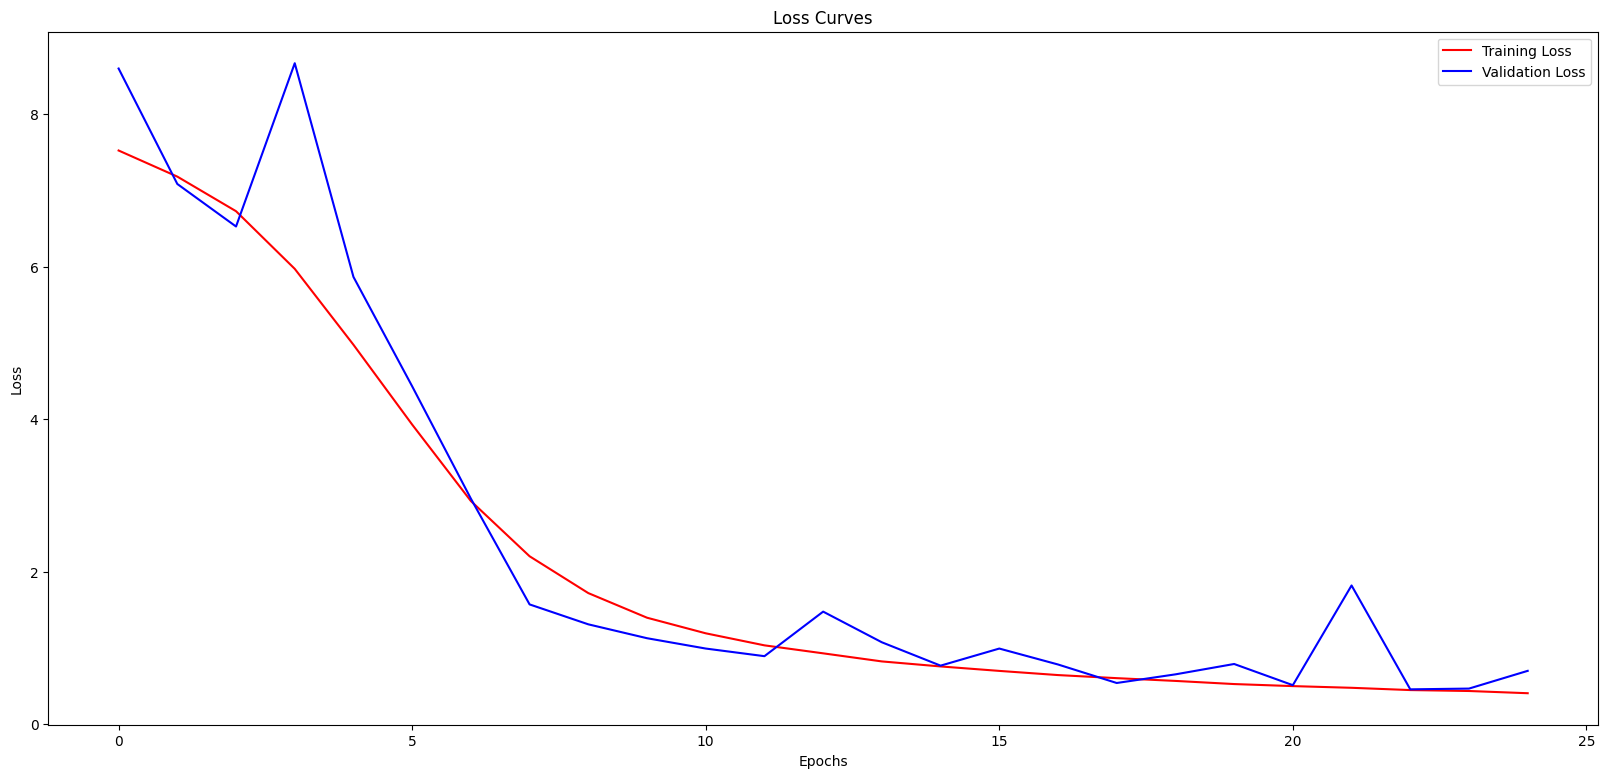

In [23]:
#Loss Curves

plt.figure(figsize=[20,9])
plt.plot(ModelHistory.history['loss'], 'r')
plt.plot(ModelHistory.history['val_loss'], 'b')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')

Text(0.5, 1.0, 'Accuracy Curves')

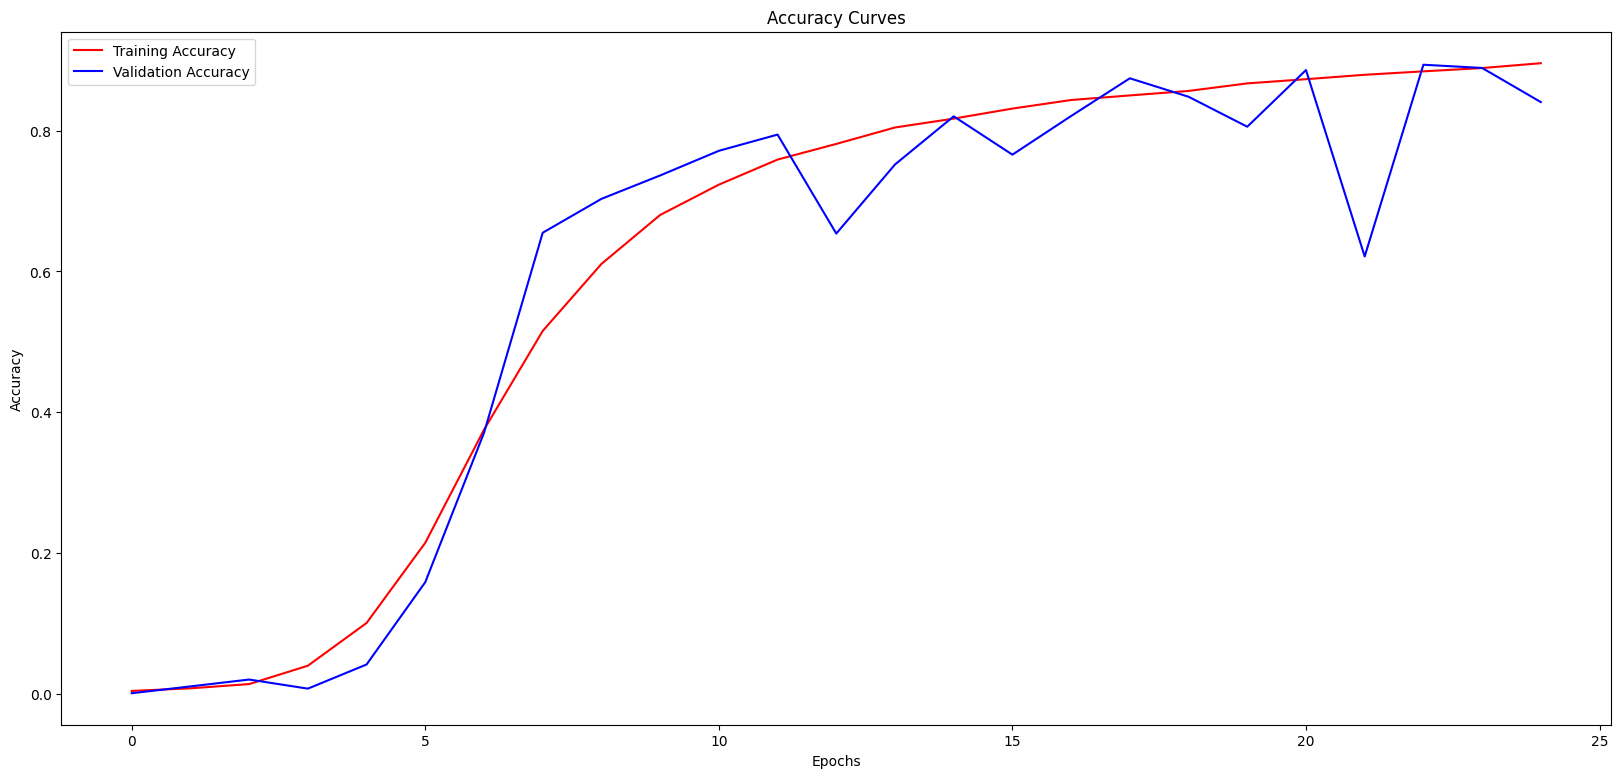

In [24]:
#Accuracy Curves
plt.figure(figsize=[20,9])
plt.plot(ModelHistory.history['accuracy'], 'r')
plt.plot(ModelHistory.history['val_accuracy'], 'b')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

# Predict in test set

In [25]:
import os

# Định nghĩa hàm predict cho mỗi ảnh
def predict_image(image_path, model, label_encoder):
    # Tiền xử lý ảnh và thực hiện dự đoán
    img_process = threshold(image_path)
    img_process = np.expand_dims(img_process, axis=0)  # Thêm chiều cho batch
    prediction = model.predict(img_process)
    label_encoded = np.argmax(prediction)
    label = label_encoder.inverse_transform([label_encoded])[0]
    
    # Trả về kết quả dự đoán
    return label

# Load ảnh từ mỗi folder và đưa ra dự đoán
def load_images_and_predict(folder, model, label_encoder):
    predictions = []
    for filename in os.listdir(folder):
        image_path = os.path.join(folder, filename)
        label = predict_image(image_path, model, label_encoder)
        predictions.append({'image_name': os.path.splitext(filename)[0], 'label': label})
    
    return predictions

# Load model từ file checkpoint đã lưu
model = load_model('model_chu_nom.keras')

# Load ảnh từ thư mục và thực hiện dự đoán
images_dir = '/kaggle/working/data_folder/wb_recognition_dataset/val/images'
predictions = load_images_and_predict(images_dir, model, label_encoder)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━

In [26]:
import pandas as pd

# Chuyển danh sách predictions thành DataFrame
predictions_df = pd.DataFrame(predictions)

predictions_df['image_name'] = predictions_df['image_name'].astype('int64')

# Sắp xếp DataFrame theo cột 'image_name'
predictions_df = predictions_df.sort_values(by='image_name')

# Lưu DataFrame vào file CSV
predictions_df.to_csv('predictions.csv', index=False)

In [27]:
labels_df = pd.read_csv('/kaggle/working/predictions.csv')

In [28]:
# Kiểm tra kiểu dữ liệu của cột 'image_name' trong labels_df
print(labels_df['image_name'].dtype)
print(labels_df['label'].dtype)
print(predictions_df['image_name'].dtype)
print(predictions_df['label'].dtype)

int64
int64
int64
object


In [ ]:
#Tính độ chính xác giữa file predict và file labels

def count_differences(file1_path, file2_path):
    count = 0

    with open(file1_path, 'r') as file1, open(file2_path, 'r') as file2:
        file1_lines = file1.readlines()
        file2_lines = file2.readlines()

        # Check if both files have the same number of lines
        if len(file1_lines) != len(file2_lines):
            raise ValueError("Files do not have the same number of lines.")

        for line1, line2 in zip(file1_lines, file2_lines):
            if line1.strip() != line2.strip():
                count += 1

    return count



file1_path = '/kaggle/working/predictions.csv'
file2_path = '/kaggle/working/data_folder/wb_recognition_dataset/val/labels.csv'
differences = count_differences(file1_path, file2_path)
print(f"Number of different lines: {differences}")
print(f"Number of similar lines: {1394 - differences}")
print("Percentage of similarity: " + str((1394 - differences) / 1394 * 100))

Number of different lines: 217
Number of similar lines: 1177
Percentage of similarity: 84.43328550932569
